# Predicting Horse Race Outcomes : using lightGBM-Ranker

1. A boosting method
2. This Ranker model can take any size of input through position normalization
3. Hyperparameters have not yet been tuned - remember to do this

In [9]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#definitions
def normalize(df, column_name):
    df_norm = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())   
    return df_norm
def convert_to_seconds(time_str):
    mins, sec, millisec = time_str.split('.')
    total_milliseconds = (int(mins)*60*1000)+ (int(sec)*1000)+ int(millisec)
    seconds = total_milliseconds/1000
    return seconds

In [3]:
#importing raw data
details_rawdata = pd.read_csv(r'race_details_20240101_20240131.csv', encoding='utf-8' )
results_rawdata = pd.read_csv(r'race_results_20240101_20240131.csv', encoding='utf-8') #to display Turkish characters correctly

**Data cleaning, pre-processing and feature-engineering:**

In [4]:
#merge race details into race results
race_combo = pd.merge(results_rawdata, details_rawdata, on=['race_date', 'race_city', 'race_no'], how='left')
race_combo['race_info'] = race_combo['race_date'].astype(str) + '_' + race_combo['race_city'] + '_' + race_combo['race_no'].astype(str)
race_combo['race_id'] = pd.factorize(race_combo['race_info'])[0] + 1 
race_combo.to_excel(r'race_combo5.xlsx', index=False)

#group by race_info and rescale 'result' column between 0 and 1
race_combo_grouped = race_combo.groupby('race_info')

race_combo['horse_age'] = race_combo['horse_age'].str.replace('y', '').astype(int)
race_combo['race_age_group'] = race_combo['race_age_group'].str.extract('(\d+)', expand=False).astype(int)
#replace abpve line with simpler grad level ver do a if statement  and replace years old and yeard and up 
#just as horse _age is done

#encoding
columns_to_encode = ['horse_age', 'race_type', 'race_age_group','race_track_type', 'race_track_condition']

race_combo = race_combo.rename(columns={'horse_race_degree': 'finish_time'})
race_combo['finish_time'] = race_combo['finish_time'].replace('Derecesiz', np.nan)# fill undetermined time 
race_combo['finish_time'] = race_combo['finish_time'].apply(lambda x: convert_to_seconds(x) if pd.notnull(x) else np.nan)

#new combination feature
race_combo['speed'] = race_combo.apply(lambda row: row['race_length'] / row['finish_time'], axis=1)
race_combo['speed'] = normalize(race_combo, 'speed')

#dropped
race_combo = race_combo.drop(['finish_time','race_length',"race_race_group","horse_rate","horse_psf_rank","best_rating",
                              "race_sex_group","Horse_starting_box_no","jockey_name","race_no","race_date",'horse_trainer', 
                              'horse_owner', 'race_city','horse_name','horse_origin', 'horse_sire','horse_dam', 'hors_broodmare_sire',
                              'horse_margin', 'horse_late_start', 'horse_accessories', 'Horse_starting_box_no' ] , axis=1)

race_combo['horse_sex'] = race_combo['horse_sex'].map({'m': 0, 'f': 1})
if set(race_combo['horse_sex']) - {0, 1}:# this checks if vals are 0 or 1 but instead of doing this count num of unique values 
    print("Invalid values found in 'horse_sex' column.")
race_combo['race_age_group'] = race_combo['race_age_group'].map({3: 0, 4: 1})
race_combo['race_track_type'] = race_combo['race_track_type'].map({"Dirt": 0, "Dirt (Polytrack)": 1})
race_combo['horse_win_value'] = race_combo['horse_win_value'].astype(float)#check if i should remove for better performance

# one-hot encode categorical columns
# rescale columns between 0 and 1
columns_to_rescale = ['jockey_weight', 'horse_win_value', 'horse_psf_rate']
for column in columns_to_rescale:
    race_combo[column] = normalize(race_combo, column)
    
for column in race_combo.columns:
    unique_values = race_combo[column].nunique()
    print(f"'no. of unique values: {column}' - {unique_values}")

race_combo_encoded = pd.get_dummies(race_combo, columns=columns_to_encode, drop_first=True)

race_combo_encoded = race_combo_encoded.dropna() #drops any rows with 0 cells , check how many dropped

# check if a column is bool and convert true to 1 and false to 0
for column in race_combo_encoded.columns:
    if race_combo_encoded[column].dtype == bool:
        race_combo_encoded[column] = race_combo_encoded[column].astype(int)#useful if exporting and importing with excel files
        #not needed for csv and df

race_combo_encodedLGBM = race_combo_encoded

#checking for missing/nan cells
nan_rows = race_combo_encoded[race_combo_encoded.isnull().any(axis=1)]
nan_row_numbers = nan_rows.index.tolist()
print(f"row numbers with nan values: {nan_row_numbers}")


'no. of unique values: result' - 19
'no. of unique values: horse_age' - 9
'no. of unique values: horse_sex' - 2
'no. of unique values: jockey_weight' - 15
'no. of unique values: horse_win_value' - 1093
'no. of unique values: horse_psf_rate' - 76
'no. of unique values: race_type' - 20
'no. of unique values: race_age_group' - 2
'no. of unique values: race_track_type' - 2
'no. of unique values: race_track_condition' - 4
'no. of unique values: race_info' - 480
'no. of unique values: race_id' - 480
'no. of unique values: speed' - 3692
row numbers with nan values: []


In [5]:
#importing cleaned data (if needed)
#race_combo_encodedLGBM = pd.read_csv(r'race_combo_encodedLGBM.csv', encoding='utf-8' )

In [6]:
#exporting clean data
#race_combo_encodedLGBM.to_csv(r'race_combo_encodedLGBM.csv', index=False)

In [7]:
# Extract testing dataset
unique_races = race_combo_encodedLGBM['race_info'].unique()[:10]
testing_dataset = race_combo_encodedLGBM[race_combo_encodedLGBM['race_info'].isin(unique_races)].copy()
race_combo_encodedLGBM = race_combo_encodedLGBM[~race_combo_encodedLGBM['race_info'].isin(unique_races)].copy()

groups = race_combo_encodedLGBM.groupby('race_id').size().values#tells you how many horses in each race
#the model will know a list of variable input sizes (group or race sizes)
X_train = race_combo_encodedLGBM.drop(columns=['result', 'race_info', 'race_id'])

#check if any nulls nans here
y_train = race_combo_encodedLGBM['result']

# Group testing dataset by race_id
testing_groups = testing_dataset.groupby('race_id')


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

#si seeded at a good acc

lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
                            n_estimators=100, subsample_for_bin=200000, random_state=42)

#y_train is ranks (1,2,3...etc)
lgb_ranker.fit(X_train, y_train, group=groups)

#initialize totals
total_match = 0
total_close = 0
total_incorrect = 0
total_rows = 0

#loop through each group and create X_test and y_test
for race_id, group in testing_groups:
    X_test = group.drop(columns=['result', 'race_info', 'race_id'])
    y_test = group['result']
    
    #perform prediction for the current group
    y_pred = lgb_ranker.predict(X_test)
    ranked_pred = pd.Series(y_pred).rank(ascending=True).tolist()
         
    comparison_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': ranked_pred
    })
    
    #update 'custom_metric' based on the conditions
    comparison_df['custom_metric'] = 'INCORRECT'  # initialize all as 'INCORRECT'
    comparison_df.loc[comparison_df['Predicted'] == comparison_df['Actual'], 'custom_metric'] = 'CORRECT'
    comparison_df.loc[(abs(comparison_df['Predicted'] - comparison_df['Actual']) <= 1) & (comparison_df['Predicted'] != comparison_df['Actual']), 'custom_metric'] = 'CLOSE'
    
    #count the number of each category
    match_count = comparison_df[comparison_df['custom_metric'] == 'CORRECT'].shape[0]
    close_count = comparison_df[comparison_df['custom_metric'] == 'CLOSE'].shape[0]
    incorrect_count = comparison_df[comparison_df['custom_metric'] == 'INCORRECT'].shape[0]
    
    #update the total counts
    total_match += match_count
    total_close += close_count
    total_incorrect += incorrect_count
    total_rows += comparison_df.shape[0]
    #print(comparison_df)

#calculate the percentages
match_percentage = (total_match / total_rows) * 100
close_percentage = (total_close / total_rows) * 100
incorrect_percentage = (total_incorrect / total_rows) * 100

#print the total counts and percentages
print(f"Total Match: {total_match} ({match_percentage:.2f}%)")
print(f"Total Close: {total_close} ({close_percentage:.2f}%)")
print(f"Total Incorrect: {total_incorrect} ({incorrect_percentage:.2f}%)")
print('example:')
comparison_df 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 4156, number of used features: 32
Total Match: 41 (53.95%)
Total Close: 23 (30.26%)
Total Incorrect: 12 (15.79%)
example:


,Actual,Predicted,custom_metric
69,1,1.0,CORRECT
70,2,2.0,CORRECT
71,3,4.0,CLOSE
72,4,3.0,CLOSE
73,5,7.0,INCORRECT
74,6,5.0,CLOSE
75,7,6.0,CLOSE


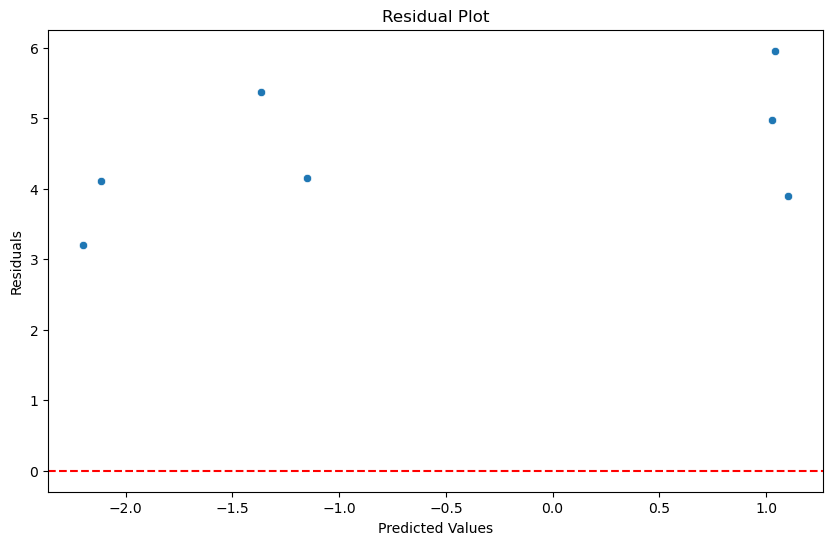

In [18]:
# 1. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [14]:
lgb.GBMRanker.evals_result_

AttributeError: module 'lightgbm' has no attribute 'GBMRanker'

In [11]:


# Feature Importance Plot
importances = lgb.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.title("Feature Importance Plot")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

AttributeError: module 'lightgbm' has no attribute 'feature_importances_'